# WeRateDogs Twitter Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gathering">Gathering Data</a></li>
<li><a href="#assessing">Assessing Data</a></li>
<li><a href="#cleaning">Cleaning Data</a></li>
<li><a href="#analysis">Exploratory Data Analysis</a></li>
<li><a href="#limitations">Limitations</a></li>
<li><a href="#conclusions">Conclusions</a></li>

<a id='intro'></a>
## Introduction

> The goal of this project is to wrangle [WeRateDogs](https://twitter.com/dog_rates?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor) Twitter data to create interesting and trustworthy analyses and visualizations. The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning of data is needed.
>
> **The Data:**
>
> *Enhanced Twitter Archive:*<br>
> Tweet data that was extracted from the tweet's text. This includes rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." Filtered 5000+ tweets for ones with ratings only (2356).
>
> *Additional Data via the Twitter API:*<br>
> Retweet count and favorite count are two of the notable column omissions from the "Enhanced Twitter Archive." This data can be gathered by anyone from Twitter's API in conjunction with the unique tweet IDs within the archive.
>
> *Image Predictions File:*<br>
> Every image in the WeRateDogs Twitter archive was passed through a neural network that can classify breeds of dogs. The results are a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).

### Perform Analysis and Visualization Imports

In [1]:
# Import analysis libraries
import numpy as np
import pandas as pd

# Import tools for pulling from API
import requests
import tweepy
import json

# Import visualization tools
from IPython.display import Image
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

# Make Plotly work within Jupyter Notebook
init_notebook_mode(connected=True)

<a id='gathering'></a>
## Gathering Data

### Perform Data Imports

#### Manually read in csv file:

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2032,671763349865160704,NaN,NaN,2015-12-01 18:50:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Mark. He's a good dog. Always rea...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671763349...,9,10,Mark,None,None,None,None


#### Programmatically download and read in tsv file:

In [3]:
# load content of the Udacity cloud file into the response:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

# Create tsv file from response:
with open('image_predictions.tsv', mode = 'wb') as file:
    # response.content is the content of the response in bytes, as opposed to response.text which is in unicode. So for 
    # this case where the file is opened in binary mode (including 'b' in the "mode" argument), response.content is used
    file.write(response.content)

image_predictions = pd.read_csv('image_predictions.tsv', sep = '\t')
image_predictions.sample()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1198,740699697422163968,https://pbs.twimg.com/media/Ckd-bqVUkAIiyM7.jpg,1,lawn_mower,0.878863,False,swing,0.024535,False,barrow,0.019577,False


#### Query the Twitter API:
First, create an API object. A Twitter dev account was created to gain access criteria for tweepy

In [4]:
# Twitter account that was created: UdacityWeRateDogs
consumer_key = #### UNIQUE CONSUMER KEY ####
consumer_secret = #### UNIQUE CONSUMER SECRET ####
access_token = #### UNIQUE ACCESS TOKEN ####
access_secret = #### UNIQUE ACCESS SECRET ####

# Setup oauth authentication using above access criteria:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

# Create API object:
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

Second, gather the relevant tweets from the Twitter API with a for loop:

In [5]:
# List of tweet ids from the enhanced twitter archive:
tweet_id_list = twitter_archive.tweet_id.tolist()
# List of tweets to populate:
tweet_list = []
# Because there may be tweets that can't be found, 
# an error list will be populated with these cases.
errors = []

for tweet_id in tweet_id_list: 
    try: 
        tweet_list.append(api.get_status(tweet_id)) 
    except Exception as e:
        # Identify the tweet_ids that cannot be found
        print(str(tweet_id) + " tweet not found")
        errors.append(tweet_id)

888202515573088257 tweet not found
873697596434513921 tweet not found
872668790621863937 tweet not found
869988702071779329 tweet not found
866816280283807744 tweet not found
861769973181624320 tweet not found
845459076796616705 tweet not found
842892208864923648 tweet not found
837012587749474308 tweet not found
827228250799742977 tweet not found
812747805718642688 tweet not found
802247111496568832 tweet not found
775096608509886464 tweet not found
770743923962707968 tweet not found


Rate limit reached. Sleeping for: 573


754011816964026368 tweet not found
680055455951884288 tweet not found


Rate limit reached. Sleeping for: 551


Third, save the json dictionaries of tweet data as `tweet_json.txt`. This allows quick access to the json data so that the time consuming API gathering only needs to be done once.

In [6]:
json_dicts = []
for element in tweet_list:
    json_dicts.append(element._json)
with open('tweet_json.txt', 'w') as file:
    file.write(json.dumps(json_dicts, indent = 4))

Finally, create a dataframe with relevant columns. For now, we'll gain insights from:<br>
`favorites` = a count of favorites for a given tweet<br>
`retweets` = a count of retweets for a given tweet<br>
`followers` = the number of followers associated with the WeRateDogs account at the time of the tweet

In [7]:
tweet_counts = []
with open('tweet_json.txt', encoding = 'utf-8') as json_file:
    all_tweets = json.load(json_file)
    for each_tweet in all_tweets:
        tweet = each_tweet['id']
        favorites = each_tweet['favorite_count']
        retweets = each_tweet['retweet_count']
        followers = each_tweet['user']['followers_count']
        tweet_counts.append({'tweet_id': str(tweet),
                             'favorite_count': int(favorites),
                             'retweet_count': int(retweets),
                             'followers_count': int(followers)})
tweet_counts_df = pd.DataFrame(tweet_counts)

In [8]:
tweet_counts_df.head()
# Looks good!

,favorite_count,followers_count,retweet_count,tweet_id
0,37985,7678664,8302,892420643555336193
1,32615,7678664,6132,892177421306343426
2,24553,7678664,4058,891815181378084864
3,41324,7678664,8434,891689557279858688
4,39503,7678664,9147,891327558926688256


<a id='assessing'></a>
## Assessing Data

Let's first observe the `twitter_archive` dataframe for quality and tidiness issues:

In [9]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [10]:
twitter_archive[twitter_archive['tweet_id'].duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


There aren't any duplicated `tweet_id`'s, but there appears to be 181 retweets based of the number of non-null objects for the retweeted columns. Let's see what these are before decided to omit them:

In [11]:
retweets_df = twitter_archive[twitter_archive['retweeted_status_user_id'].isnull() == False]
retweets_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None


Based off the text starting with "RT @", these are definitely retweets.

Let's see if there are any suspicious dog names:

In [12]:
twitter_archive['name'].value_counts()

None         745
a             55
Charlie       12
Oliver        11
Cooper        11
Lucy          11
Tucker        10
Lola          10
Penny         10
Winston        9
Bo             9
Sadie          8
the            8
Toby           7
an             7
Bailey         7
Buddy          7
Daisy          7
Oscar          6
Jax            6
Leo            6
Jack           6
Bella          6
Dave           6
Koda           6
Milo           6
Stanley        6
Scout          6
Rusty          6
Finn           5
            ... 
Storkson       1
life           1
Kathmandu      1
Brady          1
Batdog         1
Lassie         1
Margo          1
Gilbert        1
Dale           1
Bluebert       1
Banditt        1
Mya            1
Dwight         1
Spark          1
Baron          1
Tino           1
my             1
Willem         1
Remy           1
Carll          1
Al             1
Brudge         1
Ember          1
Arlo           1
Buddah         1
Jazz           1
Iroh           1
Herb          

In [13]:
lowercase_names = twitter_archive[twitter_archive['name'].str.islower() == True]['name'].unique().tolist()
lowercase_names

['such',
 'a',
 'quite',
 'not',
 'one',
 'incredibly',
 'mad',
 'an',
 'very',
 'just',
 'my',
 'his',
 'actually',
 'getting',
 'this',
 'unacceptable',
 'all',
 'old',
 'infuriating',
 'the',
 'by',
 'officially',
 'life',
 'light',
 'space']

Let's look at the range of ratings:

In [14]:
twitter_archive['rating_numerator'].min(), twitter_archive['rating_numerator'].max()

(0, 1776)

In [15]:
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [16]:
twitter_archive.loc[twitter_archive['rating_numerator'] == 1776]['text'].iloc[0]

"This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh"

In [17]:
twitter_archive['rating_denominator'].min(), twitter_archive['rating_denominator'].max()

(0, 170)

In [18]:
twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [19]:
twitter_archive.loc[twitter_archive['rating_denominator'] == 170]['text'].iloc[0]

'Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv'

Looks like the max numerator score (which happens to be the year of US independance) belongs to a patriotic dog. Most numerators are in the 10-13 range which is unusual for a 10-point scale, but an apparent trademark of this twitter account.

The max demonimator comes from evaluating a group of dogs. The zeroes may stem from posts that aren't related to dogs at all.

I'm curious as to whether or not the `rating_numerator` and `rating_denominator` extraction took decimals or multiple ratings into account. This can be checked with [extractall](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.extractall.html) and regex:

In [20]:
regex_rating = twitter_archive['text'].str.extractall('(?P<numerator>\d+\.?\d*)\/(?P<denominator>\d+)')
regex_rating['numerator'].unique(), regex_rating['denominator'].unique()

(array(['13', '12', '14', '13.5', '17', '11', '10', '420', '666', '6',
        '15', '182', '960', '0', '9.75', '007', '84', '7', '9', '24', '8',
        '1', '5', '11.27', '3', '4', '165', '1776', '204', '50', '99',
        '80', '45', '60', '2', '44', '143', '121', '20', '9.5', '11.26',
        '144', '88'], dtype=object),
 array(['10', '00', '15', '70', '7', '11', '150', '170', '20', '50', '90',
        '80', '40', '130', '110', '16', '120', '2'], dtype=object))

Looks like there are a few decimals. Let's consider a numerator of 13.5. I suspect the current dataframe has this identified as a `rating_numerator` of 5:

In [21]:
twitter_archive[twitter_archive['rating_numerator'] == 5]['text'].iloc[0]

'This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948'

Sure enough, it does. Cleaning up numerators to incorporate decimals will resolve this quality issue.

In [22]:
len(twitter_archive), len(regex_rating)

(2356, 2390)

Looks like there are 34 instances of multiple ratings. Let's check these out:

In [23]:
# .xs returns a cross section of the dataframe.
# With that, we can get a list of indexes and use iloc to examine the text:
multiple_ratings = regex_rating.xs(1,level='match').index.tolist()
list(twitter_archive.iloc[multiple_ratings]['text'])

['@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s',
 "@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",
 'RT @dog_rates: "Yep... just as I suspected. You\'re not flossing." 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ',
 '"Yep... just as I suspected. You\'re not flossing." 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ',
 'RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…',
 "RT @dog_rates: Meet Eve. She's a raging alcoholic 8/10 (would b 11/10 but pupper alcoholism is a tragic issue that I can't condone) https:/…",
 'This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ',
 'After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP ht

Some of these are acceptable as is, but some, including Bretagne the 9/11 dog and Darrel the 7/11 dog, need to be changed

In [24]:
twitter_archive[twitter_archive['rating_denominator'] == 11]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1662,682962037429899265,NaN,NaN,2016-01-01 16:30:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darrel. He just robbed a 7/11 and is i...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682962037...,7,11,Darrel,None,None,None,None


### twitter_archive
>**Quality**
>
> - Incorrect datatype for `tweet_id`, `rating_numerator`, and `timestamp`
> - Retweets and their related columns aren't relevant (`in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`)
> - Incorrect dog names. Names that start with a lowercase letter include a, the, an. There's also 745 dogs named "None"
> - Rating inconsistencies: numerator ranges from 0 to 1776, denominator ranges from 0 to 170. Decimals aren't captured in numerator. Wrong rating is sometimes used in cases with multiple ratings.
>
>**Tidiness**
>
> - Dog stages (doggo, floofer, pupper, puppo) should be merged into one column

Now let's observe the `image_predictions` dataframe for quality and tidiness issues:

In [25]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [26]:
image_predictions[image_predictions['tweet_id'].duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [27]:
image_predictions[image_predictions['jpg_url'].duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
1364,761371037149827077,https://pbs.twimg.com/tweet_video_thumb/CeBym7...,1,brown_bear,0.713293,False,Indian_elephant,0.172844,False,water_buffalo,0.038902,False
1368,761750502866649088,https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg,1,golden_retriever,0.586937,True,Labrador_retriever,0.398260,True,kuvasz,0.005410,True
1387,766078092750233600,https://pbs.twimg.com/media/ChK1tdBWwAQ1flD.jpg,1,toy_poodle,0.420463,True,miniature_poodle,0.132640,True,Chesapeake_Bay_retriever,0.121523,True
1407,770093767776997377,https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg,1,golden_retriever,0.843799,True,Labrador_retriever,0.052956,True,kelpie,0.035711,True
1417,771171053431250945,https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg,3,Samoyed,0.978833,True,Pomeranian,0.012763,True,Eskimo_dog,0.001853,True


There aren't any duplicated tweet_id's, but there appears to be 66 duplicated 'jpg_url'. I would expect these to disappear once the dataframes are merged and retweets are deleted.

Let's look at cases where the image prediction tool didn't identify a dog:

In [28]:
no_dog = image_predictions[(image_predictions['p1_dog'] == False) &
                  (image_predictions['p2_dog'] == False) &
                  (image_predictions['p3_dog'] == False)]
no_dog

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,4.588540e-02,False,terrapin,1.788530e-02,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,3.391940e-02,False,partridge,5.206580e-05,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,8.554740e-02,False,bookcase,7.947970e-02,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,1.525000e-02,False,great_grey_owl,1.320720e-02,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,2.402450e-03,False,hamster,4.608630e-04,False
29,666411507551481857,https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg,1,coho,0.404640,False,barracouta,2.714850e-01,False,gar,1.899450e-01,False
45,666786068205871104,https://pbs.twimg.com/media/CUDmZIkWcAAIPPe.jpg,1,snail,0.999888,False,slug,5.514170e-05,False,acorn,2.625800e-05,False
50,666837028449972224,https://pbs.twimg.com/media/CUEUva1WsAA2jPb.jpg,1,triceratops,0.442113,False,armadillo,1.140710e-01,False,common_iguana,4.325530e-02,False
51,666983947667116034,https://pbs.twimg.com/media/CUGaXDhW4AY9JUH.jpg,1,swab,0.589446,False,chain_saw,1.901420e-01,False,wig,3.450970e-02,False
53,667012601033924608,https://pbs.twimg.com/media/CUG0bC0U8AAw2su.jpg,1,hyena,0.987230,False,African_hunting_dog,1.260080e-02,False,coyote,5.735010e-05,False


324 instances of zero dog predictions. I'm skeptical that this accurately reflects whether or not a dog is in the associated picture. I'll create a function to see if I can quickly find some exceptions:

In [29]:
# Create function for quickly displaying the leading prediction, confidence interval, and associated image
def display_image(tweet_id):
    image_row = image_predictions[image_predictions['tweet_id'] == tweet_id]
    image_url = image_row['jpg_url'].iloc[0]
    image_prediction = image_row['p1'].iloc[0]
    image_pred_conf = str(image_row['p1_conf'].iloc[0])
    print('Leading prediction and confidence interval: ' + image_prediction + ', ' + image_pred_conf)
    return Image(image_url, width = 250)

Leading prediction and confidence interval: swab, 0.589446


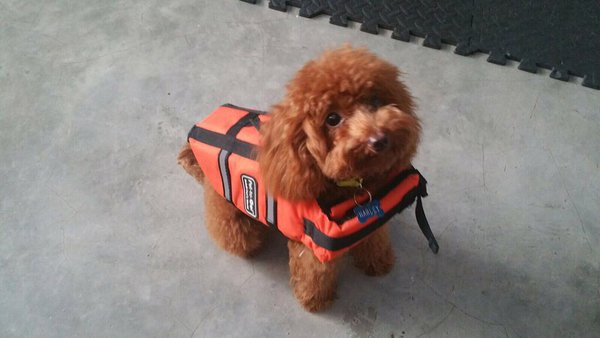

In [30]:
display_image(666983947667116034)

This looks like a dog in a life jacket, not a swab

Leading prediction and confidence interval: jigsaw_puzzle, 1.0


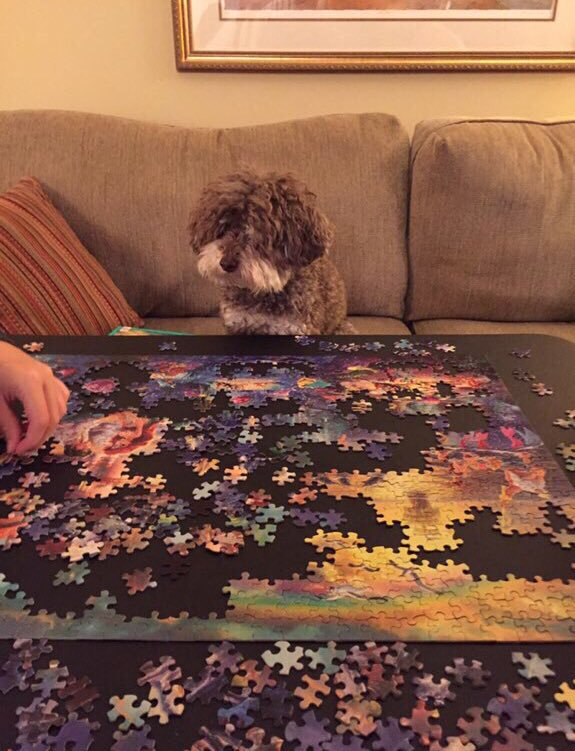

In [31]:
display_image(667866724293877760)

The algorithm was sure this is a picture of a puzzle, but it would be inaccurate to say this isn't a picture of a dog as well.

Leading prediction and confidence interval: hippopotamus, 0.581403


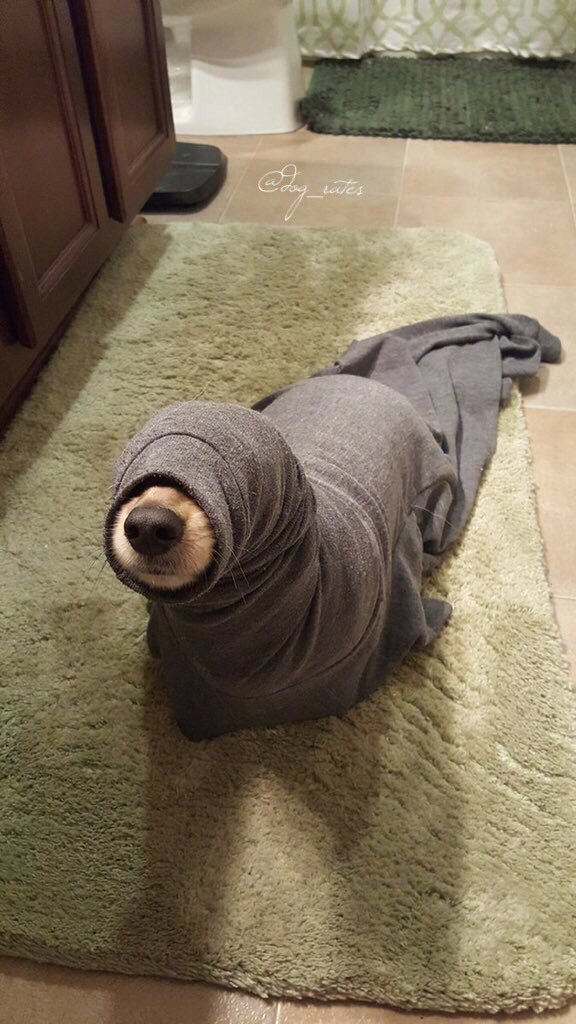

In [32]:
display_image(703041949650034688)

It's hard to blame the algorithm for getting this one wrong, but this picture definitely features a dog.

Leading prediction and confidence interval: tusker, 0.473303


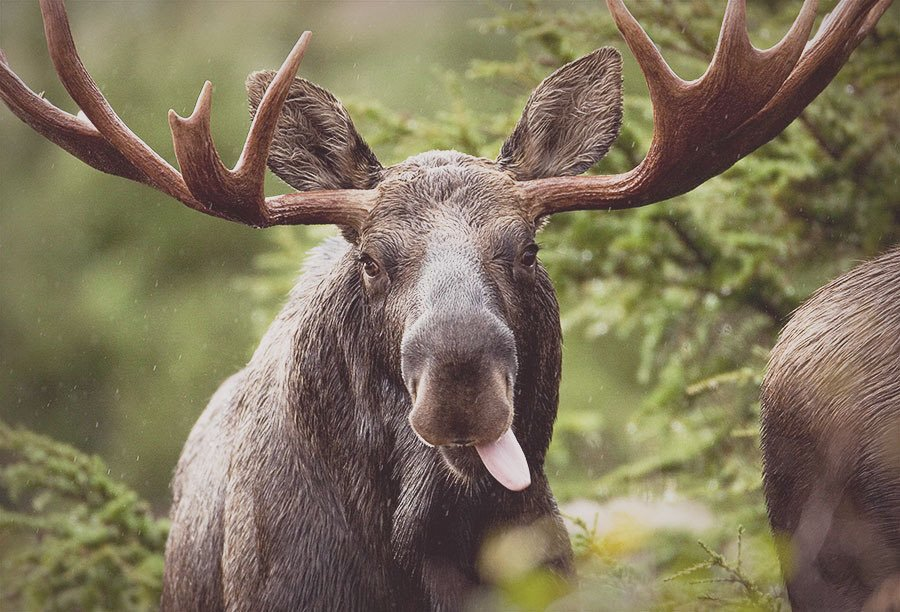

In [33]:
display_image(881268444196462592)

This isn't a dog, but maybe I could've confirmed that through the tweet's text or rating:

In [34]:
twitter_archive[twitter_archive['tweet_id'] == 881268444196462592]['text'].iloc[0]

"Meet Elliot. He's a Canadian Forrest Pup. Unusual number of antlers for a dog. Sneaky tongue slip to celebrate #Canada150. 12/10 would pet https://t.co/cgwJwowTMC"

The text jokingly calls this moose a dog, and the "dog" scored a typical 12/10. It might be tough to determine whether or not there's a dog in these scenarios...

The above are examples where all three predictions are non-dog. I noticed a row where the leading prediction was for a non-dog, but the other less confident predictions identified a dog. There are 101 cases like this:

In [35]:
two_dogs = image_predictions[(image_predictions['p1_dog'] == False) &
                  (image_predictions['p2_dog'] == True) &
                  (image_predictions['p3_dog'] == True)]
len(two_dogs)

101

In [36]:
image_predictions[image_predictions['tweet_id'] == 841833993020538882]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1858,841833993020538882,https://pbs.twimg.com/ext_tw_video_thumb/81742...,1,ice_bear,0.3362,False,Samoyed,0.201358,True,Eskimo_dog,0.186789,True


Leading prediction and confidence interval: ice_bear, 0.3362


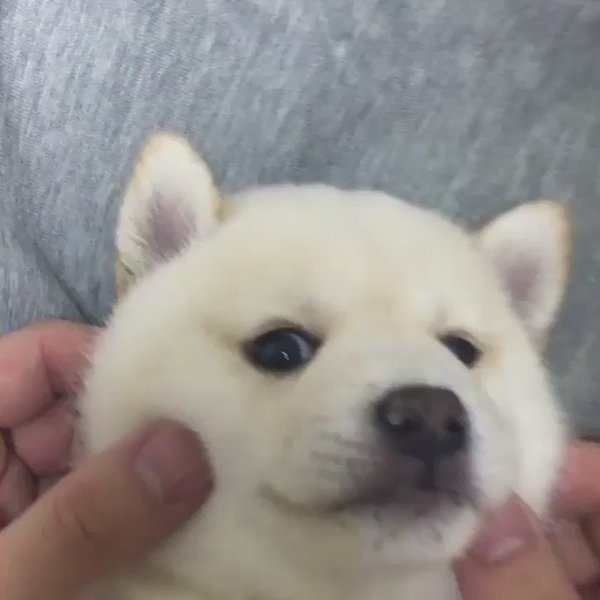

In [37]:
display_image(841833993020538882)

It's tough to tell, but it seems this dog is probably either a Samoyed or Eskimo Dog as identified in the less confident predictions.

There are 118 cases where the leading predictor isn't a dog, but one of the other two are:

In [38]:
one_dog = image_predictions[
    ((image_predictions['p1_dog'] == False) &
    (image_predictions['p2_dog'] == True) &
    (image_predictions['p3_dog'] == False)) |
    ((image_predictions['p1_dog'] == False) &
    (image_predictions['p2_dog'] == False) &
    (image_predictions['p3_dog'] == True))]
len(one_dog)

118

In [39]:
image_predictions[image_predictions['tweet_id'] == 763103485927849985]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1375,763103485927849985,https://pbs.twimg.com/media/CpcWknPXYAAeLP9.jpg,2,seat_belt,0.685821,False,ice_bear,0.081597,False,chow,0.039085,True


Leading prediction and confidence interval: seat_belt, 0.685821


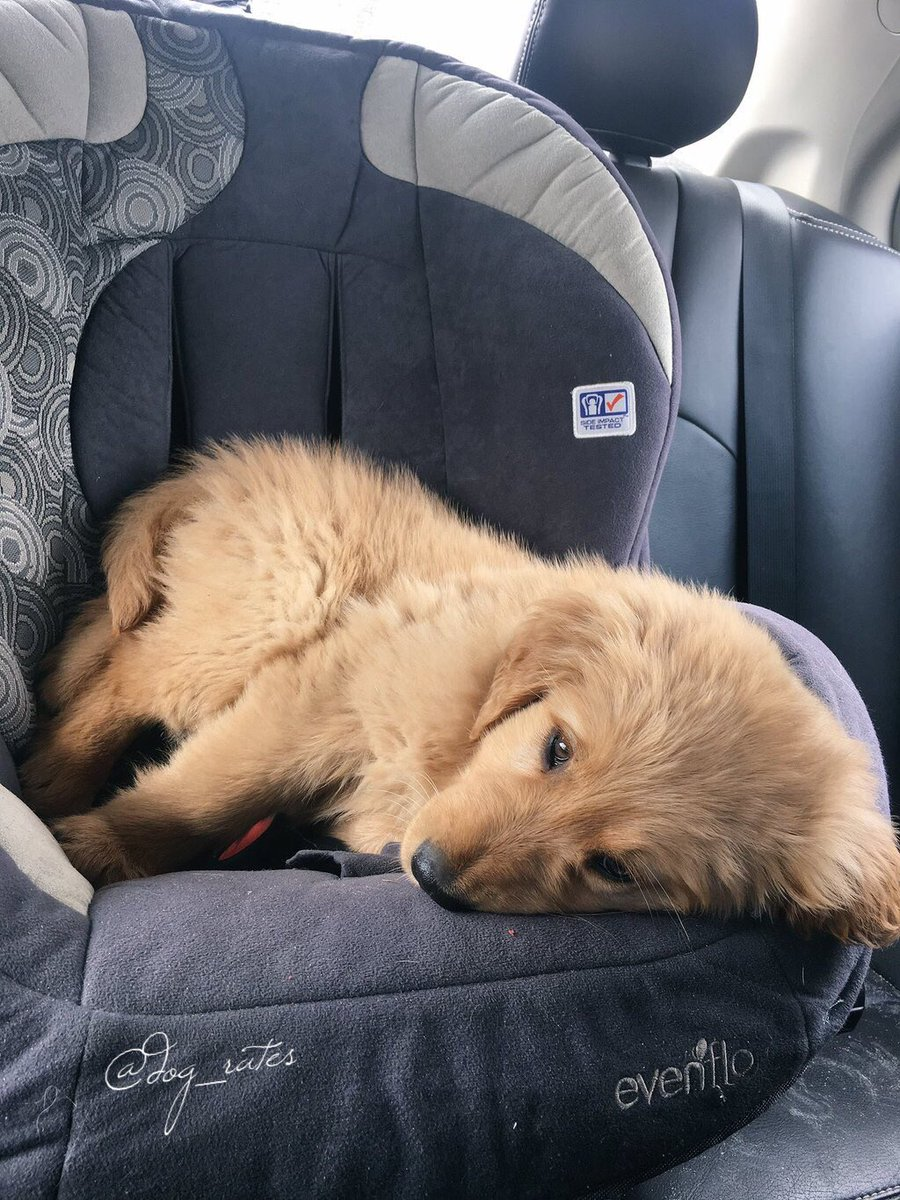

In [40]:
display_image(763103485927849985)

There is a dog pictured, but the breed (chow) is incorrect. This seems to be the case in a lot of these one_dog scenarios.

### image_predictions
>**Quality**
>
> - Incorrect datatype for `tweet_id`
> - Duplicate `jpg_url` values. Will have to see if this resolves itself when retweets are removed from `twitter_archive` and dataframes are merged.
> - Image recognition algorithm inaccuracies: pictures may have a dog even when all three predictions claim there isn't a dog. There are also cases where the lead prediction isn't a dog, but one of the other two predictions correctly identifies a dog and breed. Many cases that only have one less confident dog prediction correctly identify that there is a dog pictured, but incorrectly identify the breed.
> - Clean up image prediction columns to explicitly say whether a dog is present and if the predicted breed is known.
>
>**Tidiness**
>
> - None

Finally, let's observe the `tweet_counts_df` dataframe for quality and tidiness issues:

In [41]:
tweet_counts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 4 columns):
favorite_count     2340 non-null int64
followers_count    2340 non-null int64
retweet_count      2340 non-null int64
tweet_id           2340 non-null object
dtypes: int64(3), object(1)
memory usage: 73.2+ KB


In [42]:
tweet_counts_df[tweet_counts_df['tweet_id'].duplicated()]

,favorite_count,followers_count,retweet_count,tweet_id


I originally brought in the `followers_count` variable suspecting there would be a relationship between number of followers and retweets.

In [43]:
tweet_counts_df['followers_count'].min(), tweet_counts_df['followers_count'].max()

(7677964, 7678806)

Turns out there's only about a 10,000 follower difference, which is insignificant in the context of an account with 7.6 million followers.

### tweet_counts_df
>**Quality**
>
> - Unnecessary `followers_count` column
>
>**Tidiness**
>
> - All dataframes can be merged together on the shared `tweet_id` column

<a id='cleaning'></a>
## Cleaning Data
Create copies of the original dataframes before cleaning:

In [44]:
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
tweet_counts_df_clean = tweet_counts_df.copy()

### twitter_archive_clean
>**Quality**
>
> - Incorrect datatype for `tweet_id`, `rating_numerator` and `timestamp`

**Define**
- Convert `tweet_id` from `int` to `str`
- Convert `timestamp` from object to datetime object
- `rating_numerator` datatype should resolve itself once the regex values (which include floats) are accepted

**Code**

In [45]:
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype(str)
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])

**Test**

In [46]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](

In [47]:
twitter_archive_clean.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1229,713761197720473600,NaN,NaN,2016-03-26 16:15:05,"<a href=""http://twitter.com/download/iphone"" r...",This is Piper. She would really like that tenn...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713761197...,12,10,Piper,None,None,None,None


> **Quality**
> - Retweets and their related columns aren't relevant (`in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`)

**Define**
- Delete retweets by deleting rows that share `tweet_id` from `retweets_df`.
- Drop `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp` columns

**Code**

In [48]:
# Delete retweets:
retweets_to_delete = retweets_df['tweet_id'].astype(str).tolist()
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['tweet_id'].isin(retweets_to_delete) == False]

In [49]:
# Delete irrelavant columns:
twitter_archive_clean = twitter_archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 
                                                    'retweeted_status_user_id', 'retweeted_status_timestamp'], axis = 1)

**Test**

In [50]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null datetime64[ns]
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 220.9+ KB


> **Quality**
> - Incorrect dog names. Names that start with a lowercase letter include a, the, an, etc. There are also 745 dogs named "None"

**Define**
- Build a dataframe that includes the lowercase names and "None" values. Create `updated_name` column with the word following "name is" or "named" if possible.

**Code**

In [51]:
# Create a dataframe with names that need revisiting.
# This includes the lowercase names and "None" values
edit_names = lowercase_names + ['None']
edit_names_df = twitter_archive_clean[twitter_archive_clean['name'].isin(edit_names)]

In [52]:
# Create an "updated_name" column that's populated with the word after 
# "name is" or "named" phrases in the tweet:
updated_names = []
for tweet in twitter_archive_clean['text']:
    # If the tweet is in "edit_names_df," perform analysis.
    # If not, keep old name.
    if tweet in edit_names_df['text'].tolist():
        # If "named" or "name is" in the tweet, append the following word as the name.
        if 'named' in tweet:
            updated_names.append(tweet.split('named ')[1].split(' ')[0].strip('.'))
        elif 'name is' in tweet:
            updated_names.append(tweet.split('name is ')[1].split(' ')[0].strip('.'))
        # If "named" or "name is" in not in the tweet, append "None" as the name.
        else:
            updated_names.append('None')
    else:
        updated_names.append(twitter_archive_clean.loc[twitter_archive_clean['text'] == tweet]['name'].iloc[0])
twitter_archive_clean = twitter_archive_clean.assign(updated_name = pd.Series(updated_names).values)

In [53]:
# Convert "None" to null:
twitter_archive_clean['updated_name'].replace('None', np.nan, inplace = True)

**Test**

In [54]:
print('Length of old unique names list:'),
print(twitter_archive_clean['name'].nunique()),
print('Length of updated unique names list:'),
print(twitter_archive_clean['updated_name'].nunique(dropna = False))

Length of old unique names list:
956
Length of updated unique names list:
956


That seems a little strange... perhaps the number of the unique names that were found is equal to the numbers of names that were in the `edit_names` list

In [55]:
# Find the set of differences of two arrrays with np.setdiff1d:
different_names = np.setdiff1d(twitter_archive_clean['updated_name'].tolist(),twitter_archive_clean['name'].tolist())
different_names

array(['Alfonso', 'Alfredo', 'Alphred', 'Berta', 'Big', 'Charley',
       'Cherokee', 'Chuk', 'Daryl', 'Guss', 'Hemry', 'Howard', 'Jacob',
       'Johm', 'Kip', 'Klint', 'Kohl', 'Leroi', 'Octaviath', 'Pepe',
       'Sabertooth', 'Spork', 'Thea', 'Tickles', 'Wylie', 'nan'],
      dtype='<U14')

In [56]:
print('Length of edit_names list:'),
print(len(edit_names)),
print('Length of unique differences between old and new names:'),
print(len(different_names))

Length of edit_names list:
26
Length of unique differences between old and new names:
26


In [57]:
# Confirm edit_names are not in updated_name column:
twitter_archive_clean[twitter_archive_clean['updated_name'].isin(edit_names)]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,updated_name


It looks like that's exactly what happened. And as a sanity check, the above line shows that no values from the `edit_names` list are in the `updated_name` column. The loop worked as intended and invalid names were successfully replaced. Let's take a quick look at this name "Big" before closing this item out:

In [58]:
twitter_archive_clean.loc[twitter_archive_clean['updated_name'] == 'Big']['text'].iloc[0]

'Another topnotch dog. His name is Big Jumpy Rat. Massive ass feet. Superior tail. Jumps high af. 12/10 great pup https://t.co/seESNzgsdm'

In assessing accuracy of rating extraction, I noticed a dog named Bretagne that didn't have her name identified. Let's check this out as well:

In [59]:
list(twitter_archive_clean[twitter_archive_clean['text'].str.contains('Bretagne')]['text'])

['After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ']

Looks like lack of name identification may come from cases with a lowercase "this is" preceding the name. A more reproducable method would be to use regex to identify the names in these scenarios, but in the interest of saving time and the few instances of this happening, I will manually replace these when replacing the "Big" name.

In [60]:
list(twitter_archive_clean[twitter_archive_clean['text'].str.contains('this is')]['text'])

["I usually only share these on Friday's, but this is Blue. He's a very smoochable pooch who needs your help. 13/10\n\nhttps://t.co/piiX0ke8Z6 https://t.co/1UHrKcaCiO",
 "I've been informed by multiple sources that this is actually a dog elf who's tired from helping Santa all night. Pupgraded to 12/10",
 'Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn',
 'We only rate dogs... this is a Taiwanese Guide Walrus. Im getting real heckin tired of this. Please send dogs. 10/10 https://t.co/49hkNAsubi',
 "No no no this is all wrong. The Walmart had to have run into the dog driving the car. 10/10 someone tell him it's ok\nhttps://t.co/fRaTGcj68A",
 "For anyone who's wondering, this is what happens after a doggo catches it's tail... 11/10 https://t.co/G4fNhzelDv",
 'After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVg

**Define**
- Change "Big" to "Big Jumpy Rat." Delete the old name column.
- Populate names for Blue, Bretagne, and Yoshi.

**Code**

In [61]:
twitter_archive_clean.loc[twitter_archive_clean['updated_name'] == 'Big']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,updated_name
2267,667524857454854144,2015-11-20 02:08:22,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Another topnotch dog. His name is Big Jumpy Ra...,https://twitter.com/dog_rates/status/667524857...,12,10,None,None,None,None,None,Big


In [62]:
# Replace 'Big' with 'Big Jumpy Rat':
twitter_archive_clean.at[2267, 'updated_name'] = 'Big Jumpy Rat'

In [63]:
twitter_archive_clean[(twitter_archive_clean['text'].str.contains('this is Blue')) |
                      (twitter_archive_clean['text'].str.contains('this is Bretagne')) |
                      (twitter_archive_clean['text'].str.contains('this is Yoshi'))]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,updated_name
349,831650051525054464,2017-02-14 23:43:18,"<a href=""http://twitter.com/download/iphone"" r...","I usually only share these on Friday's, but th...","http://www.gofundme.com/bluethewhitehusky,http...",13,10,None,None,None,None,None,NaN
1068,740373189193256964,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None,NaN
1842,675870721063669760,2015-12-13 02:51:51,"<a href=""http://twitter.com/download/iphone"" r...",&amp; this is Yoshi. Another world record cont...,https://twitter.com/dog_rates/status/675870721...,11,10,None,None,None,None,None,NaN


In [64]:
twitter_archive_clean.at[349, 'updated_name'] = 'Blue'
twitter_archive_clean.at[1068, 'updated_name'] = 'Bretagne'
twitter_archive_clean.at[1842, 'updated_name'] = 'Yoshi'

In [65]:
# Delete old 'name' column:
twitter_archive_clean = twitter_archive_clean.drop(['name'], axis = 1)

**Test**

In [66]:
twitter_archive_clean[(twitter_archive_clean['updated_name'] == 'Big Jumpy Rat') |
                       (twitter_archive_clean['updated_name'] == 'Blue') |
                       (twitter_archive_clean['updated_name'] == 'Bretagne') |
                       (twitter_archive_clean['updated_name'] == 'Yoshi')]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,doggo,floofer,pupper,puppo,updated_name
349,831650051525054464,2017-02-14 23:43:18,"<a href=""http://twitter.com/download/iphone"" r...","I usually only share these on Friday's, but th...","http://www.gofundme.com/bluethewhitehusky,http...",13,10,None,None,None,None,Blue
779,775842724423557120,2016-09-13 23:44:54,"<a href=""http://twitter.com/download/iphone"" r...",This is Blue. He was having an average day unt...,https://twitter.com/dog_rates/status/775842724...,12,10,None,None,None,None,Blue
1068,740373189193256964,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,Bretagne
1842,675870721063669760,2015-12-13 02:51:51,"<a href=""http://twitter.com/download/iphone"" r...",&amp; this is Yoshi. Another world record cont...,https://twitter.com/dog_rates/status/675870721...,11,10,None,None,None,None,Yoshi
2267,667524857454854144,2015-11-20 02:08:22,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Another topnotch dog. His name is Big Jumpy Ra...,https://twitter.com/dog_rates/status/667524857...,12,10,None,None,None,None,Big Jumpy Rat


The old `name` column is gone and the four name replacements were made successfully.

> **Quality**
> - Rating inconsistencies: numerator ranges from 0 to 1776, denominator ranges from 0 to 170. Decimals aren't captured in numerator. Wrong rating is sometimes used in cases with multiple ratings.

**Define**
- Replace `rating_numerator` and `rating_denominator` with the ones that were found through regex. Manually choose the most appropriate rating in cases where there are multiple ratings. Add `rating_factor` column that "normalizes" the rating system (Divide numerator by denominator).

**Code**

In [67]:
# Create regex_rating dataframe that's populated with regex matches:
regex_rating = twitter_archive_clean['text'].str.extractall('(?P<numerator>\d+\.?\d*)\/(?P<denominator>\d+)')
# Isolate the first matches:
# .xs takes a cross-section of the dataframe.
first_rating = regex_rating.xs(0, level = 'match')
# Isolate the second matches:
second_rating = regex_rating.xs(1, level = 'match')

In [68]:
print('A snapshot of a couple cases with one match and one with two')
regex_rating.loc[54:56]

A snapshot of a couple cases with one match and one with two


numerator denominator
   match                      
54 0            13          10
55 0            17          10
   1            13          10
56 0            14          10

Of the multi match scenarios, let's see which match should be used:

In [69]:
second_rating_indexes = regex_rating.xs(1,level='match').index.tolist()
list(twitter_archive_clean.loc[second_rating_indexes]['text'])

['@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s',
 "@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",
 '"Yep... just as I suspected. You\'re not flossing." 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ',
 'This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ',
 'After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ',
 'Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a',
 'This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq',
 "Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10\nget it together Flurp https://t.co/Akzl5ynMmE",
 'This is Socks. That water pup w the super legs just splashed

Not all of these should accept the second match or regex rating. In cases where there are multiple dogs, I will keep the rating associated with the name that is identified for the row (the first regex match). However, for 4/20, 9/11, and 7/11 dogs, for example, the second regex match is more appropriate. From visual inspection, we want to keep the rating associated with the second regex match for the following rows:

In [70]:
change_rating_list = [55,313,1068,1165,1202,1459,1662,2335]

In [71]:
list(twitter_archive_clean.loc[change_rating_list]['text'])

['@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s',
 "@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",
 'After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ',
 'Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a',
 'This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq',
 "This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_) https://t.co/uaJmNgXR2P",
 'This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5',
 'This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv']

I'll build a `ratings_to_add dataframe` that has the appropriate numerators and denominators to add to `twitter_archive_clean`

In [72]:
# Drop indexes from first_rating that won't be used:
ratings_from_first_match = first_rating.drop(change_rating_list)
# Isolate indexes from second_rating that will be used:
ratings_from_second_match = second_rating[second_rating.index.isin(change_rating_list)]
# Concatenate and sort index:
ratings_to_add = pd.concat([ratings_from_first_match, ratings_from_second_match]).sort_index()
ratings_to_add.sample()

,numerator,denominator
474,12,10


In [73]:
# Confirm length matches that of twitter_archive_clean:
len(ratings_to_add) == len(twitter_archive_clean)

True

Add `regex_numerator` and `regex_denominator` columns to `twitter_archive_clean`:

In [74]:
twitter_archive_clean = twitter_archive_clean.assign(regex_numerator = pd.Series(ratings_to_add['numerator']).values)
twitter_archive_clean = twitter_archive_clean.assign(regex_denominator = pd.Series(ratings_to_add['denominator']).values)

**Test**

In [75]:
twitter_archive_clean.loc[2334:2336]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,doggo,floofer,pupper,puppo,updated_name,regex_numerator,regex_denominator
2334,666293911632134144,2015-11-16 16:37:02,"<a href=""http://twitter.com/download/iphone"" r...",This is a funny dog. Weird toes. Won't come do...,https://twitter.com/dog_rates/status/666293911...,3,10,None,None,None,None,NaN,3,10
2335,666287406224695296,2015-11-16 16:11:11,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,https://twitter.com/dog_rates/status/666287406...,1,2,None,None,None,None,NaN,9,10
2336,666273097616637952,2015-11-16 15:14:19,"<a href=""http://twitter.com/download/iphone"" r...",Can take selfies 11/10 https://t.co/ws2AMaNwPW,https://twitter.com/dog_rates/status/666273097...,11,10,None,None,None,None,NaN,11,10


In [76]:
np.setdiff1d(twitter_archive_clean['regex_numerator'].tolist(),twitter_archive_clean['rating_numerator'].tolist())

array(['007', '11.26', '11.27', '13.5', '9.5', '9.75'], dtype='<U5')

The appropriate ratings were brought in successfully! Here we see the 3 1/2 legged dog has a rating of 9/10 instead of 1/2. Now `rating_numerator` and `rating_denominator` can be deleted and `rating_factor` can be calculated.

**Code**

In [77]:
# Convert to numeric:
twitter_archive_clean['regex_numerator'] = pd.to_numeric(twitter_archive_clean['regex_numerator'])
twitter_archive_clean['regex_denominator'] = pd.to_numeric(twitter_archive_clean['regex_denominator'])
# Create 'rating_factor' column:
twitter_archive_clean['rating_factor'] = twitter_archive_clean['regex_numerator']/twitter_archive_clean['regex_denominator']
# Drop old rating columns:
twitter_archive_clean = twitter_archive_clean.drop(['rating_numerator', 'rating_denominator'], axis = 1)

**Test**

In [78]:
twitter_archive_clean.sample()

,tweet_id,timestamp,source,text,expanded_urls,doggo,floofer,pupper,puppo,updated_name,regex_numerator,regex_denominator,rating_factor
545,805826884734976000,2016-12-05 17:31:15,"<a href=""http://twitter.com/download/iphone"" r...",This is Duke. He is not a fan of the pupporazz...,https://twitter.com/dog_rates/status/805826884...,None,None,None,None,Duke,12.0,10,1.2


In [79]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id             2175 non-null object
timestamp            2175 non-null datetime64[ns]
source               2175 non-null object
text                 2175 non-null object
expanded_urls        2117 non-null object
doggo                2175 non-null object
floofer              2175 non-null object
pupper               2175 non-null object
puppo                2175 non-null object
updated_name         1425 non-null object
regex_numerator      2175 non-null float64
regex_denominator    2175 non-null int64
rating_factor        2175 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(9)
memory usage: 317.9+ KB


Columns and datatypes look good as far as ratings are concerned.

>**Tidiness**
> - Dog stages (doggo, floofer, pupper, puppo) should be merged into one column

**Define**
- Create `dog_stage` column by summing strings from `doggo`, `floofer`, `pupper`, and `puppo` columns. Replace the unique string combinations with the approriate stage.

**Code**

In [80]:
twitter_archive_clean['dog_stage'] = twitter_archive_clean['doggo'] +\
                                     twitter_archive_clean['floofer'] +\
                                     twitter_archive_clean['pupper'] +\
                                     twitter_archive_clean['puppo']
twitter_archive_clean['dog_stage'].value_counts()

NoneNoneNoneNone        1831
NoneNonepupperNone       224
doggoNoneNoneNone         75
NoneNoneNonepuppo         24
doggoNonepupperNone       10
NoneflooferNoneNone        9
doggoflooferNoneNone       1
doggoNoneNonepuppo         1
Name: dog_stage, dtype: int64

In [81]:
# Define dictionary for replacement values:
replacement_dict = {'NoneNoneNoneNone': np.nan,
                    'NoneNonepupperNone': 'pupper',
                    'doggoNoneNoneNone': 'doggo',
                    'NoneNoneNonepuppo': 'puppo',
                    'doggoNonepupperNone': 'mulitple',
                    'NoneflooferNoneNone': 'floofer',
                    'doggoNoneNonepuppo': 'mulitple',
                    'doggoflooferNoneNone': 'mulitple'}

# Define function to replace from dictionary:
def replace_from_dict(string,dictionary):
    for i,j in dictionary.items():
        # Replace the dictionary key with the dictionary value
        string = string.replace(i,j)
    return string

In [82]:
# Use function to clean up 'dog_stage' column:
twitter_archive_clean['dog_stage'] = replace_from_dict(twitter_archive_clean['dog_stage'],replacement_dict)
# Delete 'doggo', 'floofer', 'pupper', and 'puppo' columns:
twitter_archive_clean = twitter_archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis = 1)

**Test**

In [83]:
twitter_archive_clean['dog_stage'].value_counts()

pupper      224
doggo        75
puppo        24
mulitple     12
floofer       9
Name: dog_stage, dtype: int64

In [84]:
twitter_archive_clean.sample()

,tweet_id,timestamp,source,text,expanded_urls,updated_name,regex_numerator,regex_denominator,rating_factor,dog_stage
1940,673716320723169284,2015-12-07 04:11:02,"<a href=""http://twitter.com/download/iphone"" r...",The millennials have spoken and we've decided ...,NaN,NaN,1.0,10,0.1,NaN


### image_predictions
>**Quality**
>
> - Incorrect datatype for `tweet_id`

**Define**
- Convert `tweet_id` from `int` to `str`

**Code**

In [85]:
image_predictions_clean['tweet_id'] = image_predictions_clean['tweet_id'].astype(str)

**Test**

In [86]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


>**Quality**
>
> - Image recognition algorithm inaccuracies: pictures may have a dog even when all three predictions claim there isn't a dog. There are also cases where the lead prediction isn't a dog, but one of the other two predictions correctly identifies a dog and breed. Many cases that only have one less confident dog prediction correctly identify that there is a dog pictured, but incorrectly identify the breed.
>
> - Clean up image prediction columns to explicitly say whether a dog is present and if the predicted breed is known.

In [87]:
image_predictions_clean.sample()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1457,777684233540206592,https://pbs.twimg.com/media/CsrjryzWgAAZY00.jpg,1,cocker_spaniel,0.253442,True,golden_retriever,0.16285,True,otterhound,0.110921,True


**Define**
- Identify if the tweet contains a dog and if the breed can be determined via the following table. These decisions were made by looking at images satisfying each of the scenarios and determining the most likely outcome regarding the presence of a dog and its breed. This isn't perfect, but it will tidy up the nine prediction related columns into two new columns (`is_dog`, `breed`).
    
|Scenario|`is_dog`|`breed`|
|---|---|---|
|`p1_dog` = `True`|Yes|`p1`|
|`p1_dog` = `False` and `p2_dog` = `True` and `p3_dog` = `True`|Yes|`p2`|
|`p1_dog` = `False` and `p2_dog` = `True` or `p3_dog` = `True`|Yes|Unknown|
|`p1_dog` = `False` and `p2_dog` = `False` and `p3_dog` = `False`|No|`np.nan`|

**Code**

In [88]:
is_dog_list = []
breed_list = []
for index, row in image_predictions_clean.iterrows():
    if row['p1_dog'] is True:
        is_dog_list.append('Yes')
        breed_list.append(row['p1'])
    if (row['p1_dog'] is False) & (row['p2_dog'] + row['p3_dog'] == 2):
        is_dog_list.append('Yes')
        breed_list.append(row['p2'])
    if (row['p1_dog'] is False) & (row['p2_dog'] + row['p3_dog'] == 1):
        is_dog_list.append('Yes')
        breed_list.append('Unknown')
    if (row['p1_dog'] + row['p2_dog'] + row['p3_dog'] == 0):
        is_dog_list.append('No')
        breed_list.append(np.nan)
image_predictions_clean = image_predictions_clean.assign(is_dog = pd.Series(is_dog_list).values)
image_predictions_clean = image_predictions_clean.assign(breed = pd.Series(breed_list).values)

**Test**

In [89]:
scenario_examples = ['687460506001633280', '881268444196462592', '841833993020538882', '763103485927849985']
image_predictions_clean[image_predictions_clean['tweet_id'].isin(scenario_examples)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,is_dog,breed
742,687460506001633280,https://pbs.twimg.com/media/CYpZrtDWwAE8Kpw.jpg,1,Boston_bull,0.223366,True,boxer,0.183596,True,French_bulldog,0.176916,True,Yes,Boston_bull
1375,763103485927849985,https://pbs.twimg.com/media/CpcWknPXYAAeLP9.jpg,2,seat_belt,0.685821,False,ice_bear,0.081597,False,chow,0.039085,True,Yes,Unknown
1858,841833993020538882,https://pbs.twimg.com/ext_tw_video_thumb/81742...,1,ice_bear,0.336200,False,Samoyed,0.201358,True,Eskimo_dog,0.186789,True,Yes,Samoyed
2022,881268444196462592,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,tusker,0.473303,False,Indian_elephant,0.245646,False,ibex,0.055661,False,No,NaN


The new `is_dog` and `breed` columns were populated successfully for each scenario. Now I will tidy up the dataframe by dropping the old prediction columns (`p1`, `p1_conf`, `p1_dog`, `p2`, `p2_conf`, `p2_dog`, `p3`, `p3_conf`, `p3_dog`)

**Code**

In [90]:
image_predictions_clean = image_predictions_clean.drop(['p1', 'p1_conf', 'p1_dog', 
                                                        'p2', 'p2_conf', 'p2_dog', 
                                                        'p3', 'p3_conf', 'p3_dog'], axis = 1)

**Test**

In [91]:
image_predictions_clean[image_predictions_clean['tweet_id'].isin(scenario_examples)]

,tweet_id,jpg_url,img_num,is_dog,breed
742,687460506001633280,https://pbs.twimg.com/media/CYpZrtDWwAE8Kpw.jpg,1,Yes,Boston_bull
1375,763103485927849985,https://pbs.twimg.com/media/CpcWknPXYAAeLP9.jpg,2,Yes,Unknown
1858,841833993020538882,https://pbs.twimg.com/ext_tw_video_thumb/81742...,1,Yes,Samoyed
2022,881268444196462592,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,No,NaN


>**Quality**
>
> - Duplicate `jpg_url` values. Will have to see if this resolves itself when retweets are removed from `twitter_archive` and dataframes are merged.

I'll revisit this quality issue once dataframes are merged.

### tweet_counts_df

>**Quality**
>
> - Unnecessary `followers_count` column

**Define**
- Drop `followers_count` column

**Code**

In [92]:
tweet_counts_df_clean = tweet_counts_df_clean.drop(['followers_count'], axis = 1)

**Test**

In [93]:
tweet_counts_df_clean.head()

,favorite_count,retweet_count,tweet_id
0,37985,8302,892420643555336193
1,32615,6132,892177421306343426
2,24553,4058,891815181378084864
3,41324,8434,891689557279858688
4,39503,9147,891327558926688256


> **Tidiness**
>
> - All dataframes can be merged together on the shared `tweet_id` column

**Define**
- Merge `image_predictions_clean` with `twitter_archive_clean`. Merge the result with `tweet_counts_df_clean`. Drop unnecessary columns and rows and save as `twitter_archive_master`.

**Code**

In [94]:
(image_predictions_clean['tweet_id'].nunique(),
 twitter_archive_clean['tweet_id'].nunique(),
 tweet_counts_df_clean['tweet_id'].nunique())

(2075, 2175, 2340)

In [95]:
# The resulting dataframe should have as many unique tweet ids as image_predictions_clean.
# This is done by specifying "right" or "left" in the "how" argument of merge.
twitter_archive_master = twitter_archive_clean.merge(image_predictions_clean, on = 'tweet_id', how = 'right')
twitter_archive_master = twitter_archive_master.merge(tweet_counts_df_clean, on = 'tweet_id', how = 'left')

**Test**

In [96]:
##### CHANGE FAVORITE AND RETWEET COUNT TO INTS ####

In [97]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 16 columns):
tweet_id             2075 non-null object
timestamp            1994 non-null datetime64[ns]
source               1994 non-null object
text                 1994 non-null object
expanded_urls        1994 non-null object
updated_name         1382 non-null object
regex_numerator      1994 non-null float64
regex_denominator    1994 non-null float64
rating_factor        1994 non-null float64
dog_stage            306 non-null object
jpg_url              2075 non-null object
img_num              2075 non-null int64
is_dog               2075 non-null object
breed                1751 non-null object
favorite_count       2067 non-null float64
retweet_count        2067 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1), object(9)
memory usage: 275.6+ KB


It looks like only 1994 tweets were shared between `twitter_archive_clean` and `image_predictions_clean`. Let's confirm this:

In [98]:
# Number of differences in tweet_id between dataframes:
len(np.setdiff1d(twitter_archive_clean['tweet_id'].tolist(),image_predictions_clean['tweet_id'].tolist()))

181

Considering the length of `twitter_archive_clean` is 2175, and 2175 - 181 = 1994, it appears the merge worked as expected. Dropping rows that don't contain anything in the `text` column should clean up this master dataframe.

**Code**

In [99]:
twitter_archive_master = twitter_archive_master.dropna(subset = ['text'])

**Test**

In [100]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 16 columns):
tweet_id             1994 non-null object
timestamp            1994 non-null datetime64[ns]
source               1994 non-null object
text                 1994 non-null object
expanded_urls        1994 non-null object
updated_name         1382 non-null object
regex_numerator      1994 non-null float64
regex_denominator    1994 non-null float64
rating_factor        1994 non-null float64
dog_stage            306 non-null object
jpg_url              1994 non-null object
img_num              1994 non-null int64
is_dog               1994 non-null object
breed                1686 non-null object
favorite_count       1992 non-null float64
retweet_count        1992 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1), object(9)
memory usage: 264.8+ KB


Now we can check if this consolidated dataframe resolved the outstanding tidiness issue of repeated `jpg_url` values:

In [101]:
twitter_archive_master['jpg_url'].nunique() == twitter_archive_master['tweet_id'].nunique()

True

The number of unique `jpg_url` values matched the number of unique `tweet_id` values. Now the final step is to delete unnecessary columns (`img_num` and `source`) and save our clean dataframes.

**Code**

In [102]:
twitter_archive_master = twitter_archive_master.drop(['img_num', 'source'], axis = 1)
# Rearrange columns
twitter_archive_master = twitter_archive_master[['tweet_id', 'regex_numerator', 'regex_denominator',
                                                 'rating_factor', 'is_dog', 'dog_stage', 'breed', 
                                                 'updated_name', 'favorite_count', 'retweet_count', 
                                                 'text', 'timestamp', 'expanded_urls', 'jpg_url']]
twitter_archive_master.sample()

,tweet_id,regex_numerator,regex_denominator,rating_factor,is_dog,dog_stage,breed,updated_name,favorite_count,retweet_count,text,timestamp,expanded_urls,jpg_url
671,757393109802180609,10.0,10.0,1.0,Yes,doggo,Labrador_retriever,NaN,6153.0,1883.0,Here's a doggo completely oblivious to the dou...,2016-07-25 01:52:43,https://twitter.com/dog_rates/status/757393109...,https://pbs.twimg.com/media/CoLNAq6WAAAkmdJ.jpg


In [103]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 14 columns):
tweet_id             1994 non-null object
regex_numerator      1994 non-null float64
regex_denominator    1994 non-null float64
rating_factor        1994 non-null float64
is_dog               1994 non-null object
dog_stage            306 non-null object
breed                1686 non-null object
updated_name         1382 non-null object
favorite_count       1992 non-null float64
retweet_count        1992 non-null float64
text                 1994 non-null object
timestamp            1994 non-null datetime64[ns]
expanded_urls        1994 non-null object
jpg_url              1994 non-null object
dtypes: datetime64[ns](1), float64(5), object(8)
memory usage: 233.7+ KB


I noticed `favorite_count` and `retweet_count` were changed to floats from the merge. It also looks like there are two null values now. Let's make sure we can delete these two rows and change these back to ints.

**Code**

In [104]:
twitter_archive_master[twitter_archive_master['favorite_count'].isnull()]

,tweet_id,regex_numerator,regex_denominator,rating_factor,is_dog,dog_stage,breed,updated_name,favorite_count,retweet_count,text,timestamp,expanded_urls,jpg_url
688,754011816964026368,12.0,10.0,1.2,Yes,NaN,French_bulldog,Charlie,NaN,NaN,This is Charlie. He pouts until he gets to go ...,2016-07-15 17:56:40,https://twitter.com/dog_rates/status/754011816...,https://pbs.twimg.com/media/CnbJuPoXEAAjcVF.jpg
1388,680055455951884288,10.0,10.0,1.0,Yes,NaN,Samoyed,Sammy,NaN,NaN,"Meet Sammy. At first I was like ""that's a snow...",2015-12-24 16:00:30,https://twitter.com/dog_rates/status/680055455...,https://pbs.twimg.com/media/CW-ZRC_WQAAyFrL.jpg


In [105]:
tweet_counts_df_clean[tweet_counts_df_clean['tweet_id'].isin(['754011816964026368', '680055455951884288'])]

,favorite_count,retweet_count,tweet_id


We never had favorite_count or retweet_count for these rows, so we can delete them:

In [106]:
twitter_archive_master = twitter_archive_master[twitter_archive_master['tweet_id']\
                            .isin(['754011816964026368', '680055455951884288']) == False]

In [107]:
twitter_archive_master['favorite_count'] = twitter_archive_master['favorite_count'].astype(int)
twitter_archive_master['retweet_count'] = twitter_archive_master['retweet_count'].astype(int)

**Test**

In [108]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1992 entries, 0 to 1993
Data columns (total 14 columns):
tweet_id             1992 non-null object
regex_numerator      1992 non-null float64
regex_denominator    1992 non-null float64
rating_factor        1992 non-null float64
is_dog               1992 non-null object
dog_stage            306 non-null object
breed                1684 non-null object
updated_name         1380 non-null object
favorite_count       1992 non-null int32
retweet_count        1992 non-null int32
text                 1992 non-null object
timestamp            1992 non-null datetime64[ns]
expanded_urls        1992 non-null object
jpg_url              1992 non-null object
dtypes: datetime64[ns](1), float64(3), int32(2), object(8)
memory usage: 217.9+ KB


In [109]:
twitter_archive_master.sample()

,tweet_id,regex_numerator,regex_denominator,rating_factor,is_dog,dog_stage,breed,updated_name,favorite_count,retweet_count,text,timestamp,expanded_urls,jpg_url
1758,670433248821026816,10.0,10.0,1.0,Yes,NaN,Unknown,Sam,331,115,This is Sam. He's trying to escape the inordin...,2015-11-28 02:45:17,https://twitter.com/dog_rates/status/670433248...,https://pbs.twimg.com/media/CU3be0SWEAEqb7I.jpg


Looks good. We're finally ready to save the cleaned dataframes as csvs

**Code**

In [110]:
# Save clean dataframes to csv:
twitter_archive_master.to_csv('twitter_archive_master.csv', encoding = 'utf-8', index = False)
twitter_archive_clean.to_csv('twitter_archive_clean.csv', encoding = 'utf-8', index = False)
image_predictions_clean.to_csv('image_predictions_clean.csv', encoding = 'utf-8', index = False)
tweet_counts_df_clean.to_csv('tweet_counts_df_clean.csv', encoding = 'utf-8', index = False)

**Test**

In [111]:
twitter_archive_master = pd.read_csv('twitter_archive_master.csv')
twitter_archive_master.sample()

,tweet_id,regex_numerator,regex_denominator,rating_factor,is_dog,dog_stage,breed,updated_name,favorite_count,retweet_count,text,timestamp,expanded_urls,jpg_url
1984,666055525042405380,10.0,10.0,1.0,Yes,NaN,chow,NaN,427,236,Here is a Siberian heavily armored polar bear ...,2015-11-16 00:49:46,https://twitter.com/dog_rates/status/666055525...,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg


The cleaned csv reads in successfully! Some exploratory analysis can now be performed on this dataset.

<a id='analysis'></a>
## Exploratory Data Analysis

Let's look at twitter metrics (number of tweets, favorites, and retweets) for each breed.

In [112]:
# Create dataframe for number of tweets by breed:
tweets_by_breed = twitter_archive_master['breed'].value_counts().reset_index()
tweets_by_breed.rename(columns={'index':'breed','breed':'tweet_count'}, inplace=True)
tweets_by_breed.sample()

,breed,tweet_count
64,Norfolk_terrier,7


In [113]:
# Create dataframe for number of favorites and retweets by breed:
breed_metrics = twitter_archive_master.groupby(['breed'])['favorite_count', 'retweet_count']\
    .apply(lambda x : x.sum()).sort_values('favorite_count',ascending = False).reset_index()
breed_metrics.sample()

,breed,favorite_count,retweet_count
49,Doberman,66191,13783


In [114]:
# Merge these dataframes:
breed_metrics = breed_metrics.merge(tweets_by_breed, on = 'breed', how = 'left')
breed_metrics.head(10)

,breed,favorite_count,retweet_count,tweet_count
0,golden_retriever,1777703,525217,147
1,Labrador_retriever,1163484,368561,101
2,Unknown,1099228,358130,114
3,Pembroke,995435,272939,93
4,Chihuahua,705868,225505,85
5,Samoyed,539044,182057,40
6,French_bulldog,472516,119682,27
7,chow,409584,116886,43
8,pug,340233,101034,55
9,cocker_spaniel,314279,100541,28


In [115]:
# Add columns for number of favorites/retweets per tweet:
breed_metrics['favorites_per_tweet'] = round(breed_metrics['favorite_count']/breed_metrics['tweet_count'])
breed_metrics['retweets_per_tweet'] = round(breed_metrics['retweet_count']/breed_metrics['tweet_count'])

# This portion of the dataframe will be plotted. 
# It takes a snapshot of the breed metrics for the top breeds by favorite_count.
# Sorted by favorites_per_tweet so that the plot is ordered nicely.
breed_metrics_top = breed_metrics.head(10)
breed_metrics_top = breed_metrics_top.sort_values('favorites_per_tweet', ascending = False)

In [116]:
labels = breed_metrics['breed']
values = breed_metrics['favorite_count']

trace = [go.Pie(labels=labels, values=values, textinfo = 'none')]

layout = go.Layout(title='Percentage of Favorites by Breed')

fig = {'data':trace,'layout':layout}
iplot(fig)

Looking at popularity alone, retrievers seem to rule WeRateDogs. Goldens and labs rake in about 20% of the total favorites on all posts. This isn't awfully surprising considering 15% of the tweets on the account pertain to these two labs. Of the 10 most popular dogs, let's see who the heavy hitters are on a per tweet basis...

In [117]:
trace1 = go.Bar(
            name = 'Average Favorites per Tweet',
            x= breed_metrics_top['breed'][0:11],
            y= breed_metrics_top['favorites_per_tweet'])

trace2 = go.Bar(
            name = 'Average Retweets per Tweet',
            x= breed_metrics_top['breed'][0:11],
            y= breed_metrics_top['retweets_per_tweet'])

data = [trace1, trace2]
layout = go.Layout(
    title='Tweet Metrics by Breed',
    barmode='group')

fig = {'data':data,'layout':layout}
iplot(fig)

Here we see the two prominent retrievers near the front, but french bulldogs and samoyeds come out on top on a per tweet basis.

In [118]:
favorite_vs_rating = twitter_archive_master.groupby('rating_factor')['favorite_count']\
    .median().reset_index().rename(columns = {'favorite_count':'median_favorite_count'})
# Drop rows for uncommon rating_factors. These are one-offs that we don't care about for plotting the median.
favorite_vs_rating = favorite_vs_rating.drop(favorite_vs_rating.index[[10,13,14,17]])
favorite_vs_rating

,rating_factor,median_favorite_count
0,0.000000,13288.0
1,0.100000,6140.5
2,0.200000,1204.0
3,0.300000,1912.0
4,0.400000,3259.0
5,0.500000,1715.0
6,0.600000,1545.0
7,0.700000,1609.0
8,0.800000,1629.0
9,0.900000,2006.0


In [119]:
trace1 = go.Scatter(
            x = twitter_archive_master['rating_factor'],
            y = twitter_archive_master['favorite_count'],
            name = 'Individual Tweet',
            mode = 'markers',
            marker = dict(opacity = 0.3))

trace2 = go.Scatter(
            x = favorite_vs_rating['rating_factor'],
            y = favorite_vs_rating['median_favorite_count'],
            name = 'Median',
            mode = 'lines+markers',
            marker=dict(symbol = 'diamond' , size = 10, color = 'red'))

data = [trace1, trace2]

layout = go.Layout(
    title="Rating Factor's Effect on Favorites",
    hovermode = 'closest',
    xaxis = dict(
        title = 'Rating Factor (Rating Numerator Divided by Rating Denominator)',
        range = [-0.02,1.42]),
    yaxis = dict(
        title = 'Number of Favorites',
        range = [0,50000]))

fig = {'data':data,'layout':layout}
iplot(fig)

This plot tells us a few things. First, it makes it easy to see that most of the tweets have ratings in the 1 to 1.3 range. This is consistent with what we learned while assessing the original `twitter_archive` dataframe. Second, there seems to be an exponential increase from about 0.5 to 1.4 in number of favorites. However, a third observation would tell us that there's significant variance, so we should not automatically expect to receive tens of thousands of favorites just for posting a tweet with a 12/10 rating. It does seem pretty clear that tweets with rating factors greater than one get more favorites than those with less than one, so I don't envision WeRateDogs straying from their unusual rating system anytime soon.

<a id='limitations'></a>
## Limitations

> The quality of this dataset leaves plenty to be desired. There were many wrangling opportunities that weren't addressed in the interest of saving time. Insights would be much more reliable if the breed prediction tool was more accurate, or if the rating extraction acknowledged cases where mulitple dogs are pictured with multiple ratings.

<a id='conclusions'></a>
## Conclusions

> Many conclusions could be drawn from this dataset, but the following insights in particular were noticed after cleaning and visualizing the data:
> - Retrievers are the most popular: Goldens and labs make up about 20% of the total favorites on WeRateDog posts.
> - French bulldogs command respect: On a per tweet basis, considering the most popular ten dogs, french bulldogs actually lead the pack for average favorite count. Samoyeds narrowly edge them out for retweets, and goldens and labs still make the top five.
> - Popular ratings exceed 10/10: Most tweets have ratings in the 10/10 to 13/10 range, and users tend to favorite these posts more than ones that are less than 10/10. 